## Imports and Functions

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
import sscPhantom
import numpy
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os
from tqdm import tqdm
from scipy.ndimage import rotate
from PIL import Image
from matplotlib.colors import LogNorm
import json
import h5py 

""" Copies from sscCdi functions """

def read_probe_positions(path,filename):
    print('Reading probe positions (probe_positions)...')
    probe_positions = []
    positions_file = open(os.path.join(path,'positions',f"{filename}_001.txt"))

    line_counter = 0
    for line in positions_file:
        line = str(line)
        if line_counter >= 1:  # skip first line, which is the header
            T = 3e-3  # why did Giovanni rotated by this amount? not using this correction seems to result in an error in the number of positions
            pxl = float(line.split()[1])
            pyl = float(line.split()[0])
            px = pxl * np.cos(T) - np.sin(T) * pyl
            py = pxl * np.sin(T) + np.cos(T) * pyl
            probe_positions.append([px, py, 1, 1])
        line_counter += 1

    probe_positions = np.asarray(probe_positions)

    return probe_positions

def convert_probe_positions(dx, probe_positions, offset_topleft = 20):
    """Set probe positions considering maxroi and effective pixel size

    Args:
        difpads (3D array): measured diffraction patterns
        jason (json file): file with the setted parameters and directories for reconstruction
        probe_positions (array): each element is an 2-array with x and y probe positions
        offset_topleft (int, optional): [description]. Defaults to 20.

    Returns:
        object pixel size (float), maximum roi (int), probe positions (array)
    """    

    # Subtract the probe positions minimum to start at 0
    probe_positions[:, 0] -= np.min(probe_positions[:, 0])
    probe_positions[:, 1] -= np.min(probe_positions[:, 1])

    offset_bottomright = offset_topleft #define padding width
    probe_positions[:, 0] = 1E-6 * probe_positions[:, 0] / dx + offset_topleft #shift probe positions to account for the padding
    probe_positions[:, 1] = 1E-6 * probe_positions[:, 1] / dx + offset_topleft #shift probe positions to account for the padding

    return probe_positions, offset_bottomright

def set_object_shape(probe,dx,probe_positions, offset_topleft = 20):

    # Compute half size of diffraction patterns:
    half_size = probe.shape[-1] // 2

    probe_positions, offset_bottomright = convert_probe_positions(dx, probe_positions, offset_topleft = offset_topleft)

    maxroi        = int(np.max(probe_positions)) + offset_bottomright
    object_shape  = 2 * half_size + maxroi
    print('Object shape:',object_shape)

    return (object_shape,object_shape)

""" New functions """

def match_colorbar(ax):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    return make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1)

def propagate_beam(wavefront, experiment_params,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    
    from numpy.fft import fft2, fftshift, ifftshift, ifft2

    dx, wavelength,distance = experiment_params 
    
    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    
    elif propagator == 'fresnel':
    
        ysize, xsize = wavefront.shape
        x_array = np.linspace(-xsize/2,xsize/2-1,xsize)
        y_array = np.linspace(-ysize/2,ysize/2-1,ysize)

        fx = x_array/(xsize)
        fy = y_array/(ysize)

        FX,FY = np.meshgrid(fx,fy)
        # Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # multiply by phase-shift and inverse transform 
        a = np.exp(-1j*np.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output

def get_object_pixel(N,pixel_size,wavelength,distance):
    return wavelength*distance/(N*pixel_size)

def get_positions(scan_step,size_x,size_y):

    x_positions = np.arange(0,size_x,scan_step)
    y_positions = np.arange(0,size_y,scan_step)

    error = 0.05
    error2 = error
    
    x_pos = x_positions + np.random.normal(scale=error*scan_step,size=x_positions.shape)
    y_pos = y_positions + np.random.normal(scale=error*scan_step,size=y_positions.shape)

    x_pos_error = x_positions + np.random.normal(scale=error2*scan_step,size=x_positions.shape)
    y_pos_error = y_positions + np.random.normal(scale=error2*scan_step,size=y_positions.shape)

    return y_pos,x_pos, y_pos_error,x_pos_error

def set_object_size(x_pos,y_pos,obj_pxl_size,probe_size, gap = 10):
    return (np.int(gap + probe_size[0]+(np.max(y_pos)-np.min(y_pos))//obj_pxl_size),np.int(gap+probe_size[1]+(np.max(x_pos)-np.min(x_pos))//obj_pxl_size))


def calculate_diffraction_pattern(idx,obj,probe,wavelength,distance,obj_pxl):
    y,x = idx
    wavefront_box = probe*obj[y:y+probe.shape[0],x:x+probe.shape[1]]
    DP = np.abs(propagate_beam(wavefront_box, (obj_pxl,wavelength,distance)))**2
    return DP

def save_angles_file_CAT_standard():
    for i, angle_number in enumerate(range(tomogram.shape[0])): 
        filename = str(angle_number).zfill(4)+f"_complex_phantom_001.txt"
        line = f"Ry: {angles[i]}\tPiezoB2\tPiezoB3\tPiezoB1\t"
        with open(os.path.join(path,filename), 'w') as f:
            f.write(line)
            
def save_positions_file_CAT_standard(x,y,path,filename):
    line = f"Ry: {0}\tPiezoB2\tPiezoB3\tPiezoB1\t"
    f = open(os.path.join(path,'positions',f"{filename}_001.txt"), 'w')
    y,x = np.meshgrid(y*1e6,x*1e6) # save in microns
    f.write(line)
    columns = np.c_[y.flatten(),x.flatten()]
    for i in range(columns.shape[0]):
        f.write(f"\n{columns[i,0]}\t{columns[i,1]}")
    f.close()

def create_hdf_file(matrix,path,filename):
    difpads = np.ones((10,5,3))
    hdf_file = h5py.File(os.path.join(path,'scans',f'{filename}_001.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=matrix)
    hdf_file.close()

def rotation_Rz(matrix,angle):
    return rotate(matrix,angle,reshape=False,axes=(1,0))
    
def get_projection(angle,magnitude,phase,wavevector):
    return np.exp(-wavevector*np.sum(rotation_Rz(magnitude,angle),axis=0)) * np.exp(-1j*wavevector*np.sum(rotation_Rz(phase,angle),axis=0))
    # return wavevector*np.sum(rotation_Rz(magnitude,angle),axis=0)*np.exp(-1j*wavevector*np.sum(rotation_Rz(phase,angle),axis=0))

def save_hdf_masks(path,shape):
    path = os.path.join(path,'images')

    dbeam = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'dbeam.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=dbeam)
    hdf_file.close()
    
    empty = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'empty.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=empty)
    hdf_file.close()
    
    flat = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'flat.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=flat)
    hdf_file.close()
    
    mask = np.zeros((1,1,shape[0],shape[1]))
    hdf_file = h5py.File(os.path.join(path,f'mask.hdf5'), 'w')
    group = hdf_file.create_group('entry/data/')
    group.create_dataset("data",data=mask)
    hdf_file.close()
    return 0

def set_object_size_pxls(x_pos,y_pos,probe_size,gap=10):
    return (np.int(gap + probe_size[0]+(np.max(y_pos)-np.min(y_pos))),np.int(gap+probe_size[1]+(np.max(x_pos)-np.min(x_pos))))


def get_difpads2(frame,probe,obj_pxl,wavelength,distance,filename,path):

    dx, dy = 10, 10 # INPUT
    y_pxls = np.arange(0,phantom.shape[1]+1,dy)
    x_pxls = np.arange(0,phantom.shape[2]+1,dx)

    obj_size = set_object_size_pxls(x_pxls,y_pxls,probe.shape)

    obj = np.zeros(obj_size,dtype=complex)
    obj[5:5+frame.shape[0],5:5+frame.shape[1]] = frame
    
    random_shift_range = 3 #INPUT
    random_shift_y = [np.int(i) for i in (-1)**np.int(2*np.random.rand(1))*random_shift_range*np.random.rand(y_pxls.shape[0])] # generate random shift between -N and +N
    random_shift_x = [np.int(i) for i in (-1)**np.int(2*np.random.rand(1))*random_shift_range*np.random.rand(x_pxls.shape[0])]

    y_pxls, x_pxls = random_shift_y + y_pxls, random_shift_x + x_pxls
    y_pxls, x_pxls = y_pxls - np.min(y_pxls), x_pxls - np.min(x_pxls)
    Y_pxls, X_pxls = np.meshgrid(y_pxls,x_pxls)

    """ Convert to metric units """
    x_meters, y_meters = x_pxls*obj_pxl , y_pxls*obj_pxl
    artificial_shift = x_meters[0]
    x_meters, y_meters = x_meters - artificial_shift, y_meters - artificial_shift

    save_positions_file_CAT_standard(x_meters,y_meters,path,filename)
    probe_positions = read_probe_positions(path,filename)

    """ Loop through positions """ 
    difpads = np.zeros((X_pxls.flatten().shape[0],1,probe.shape[0],probe.shape[1]))
    counter = 0
    calculate_diffraction_pattern_partial = partial(calculate_diffraction_pattern,obj=obj,probe=probe,wavelength=wavelength,distance=distance,obj_pxl=obj_pxl)
    idx_list = [ [y,x] for y, x in zip(Y_pxls.flatten(),X_pxls.flatten()) ]
    processes = min(os.cpu_count(),32)
    with ProcessPoolExecutor(max_workers=processes) as executor:
        results = executor.map(calculate_diffraction_pattern_partial,idx_list)
        for counter, result in enumerate(results):
            difpads[counter,0,:,:] = result
    return difpads

## Set parameters and save metadata file

In [4]:
path="/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/data/ptycho3d/complex_phantom/"
N = 500 # size of Donut matrix 
nproc  = 100 # n of cores to create Donut phantom
energy = 6  #Kev
distance = 1 #meter
probe_pxl = 1.25156e-6
rescaling_factor = 8 # rescaling factor
probe_pxl = rescaling_factor*probe_pxl
speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]
wavelength = planck * speed_of_light / energy # meters
wavevector = 2*np.pi/wavelength

mdata = {"/entry/beamline/experiment": {"distance": distance*1e3, "energy": energy},
         "/entry/beamline/detector": {"pimega": {"exposure time": 10.0, "pixel size": probe_pxl*1e6}}}

json.dump(mdata,open(os.path.join(path,"mdata.json"), "w"))

# Get Donut Phantom

Phase Max Min:  6.0000005 0.0
Wrapped Phase Max Min:  3.082314 -3.1405036


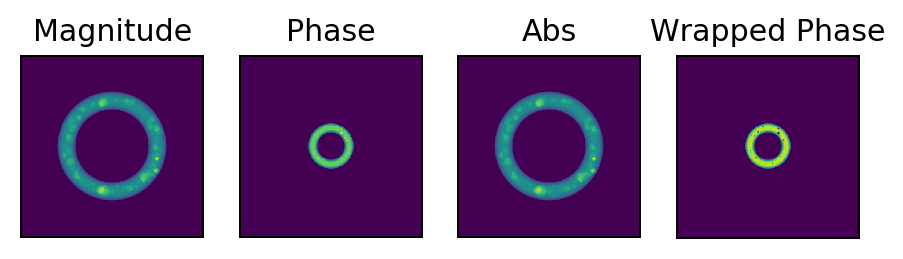

In [5]:
if 0:
    params = { 'HowMany': 3,
               'radius': 0.02,
               'Rtorus': 0.2,
               'rtorus': 0.05}
    phantom1, phantom2 = sscPhantom.donuts.createDonuts( N, nproc, energy, params )
    magnitude = phantom1 + phantom2
    magnitude = np.swapaxes(magnitude,1,0)

    params = { 'HowMany': 10,
               'radius': 0.07,
               'Rtorus': 0.5,
               'rtorus': 0.1}
    phantom1, phantom2 = sscPhantom.donuts.createDonuts( N, nproc, energy, params )
    phase = phantom1 + phantom2
    phase = np.swapaxes(phase,1,0)
    
    np.save(os.path.join(path,'magnitude.npy'),magnitude)
    np.save(os.path.join(path,'phase.npy'),phase)
else:
    # phantom = np.load(os.path.join(path,'complex_phantom.npy'))
    phase = np.load(os.path.join(path,'magnitude.npy'))
    magnitude = np.load(os.path.join(path,'phase.npy'))

    
magnitude = 0.016*magnitude/np.max(magnitude)
phase = 6*phase/np.max(phase)
    
figure, ax = plt.subplots(1,4,dpi=180)
ax[0].imshow(np.sum(magnitude,axis=0)), ax[0].set_title('Magnitude')
ax[1].imshow(np.sum(phase,axis=0)), ax[1].set_title('Phase')

print('Phase Max Min: ',np.max(phase),np.min(phase))

phantom = np.exp(-magnitude)*np.exp(1j*phase)
# phantom = phantom[:,:,0:450]
# phantom = np.roll(phantom,-20,axis=2)    
magnitude_view = -np.log(np.abs(phantom))
phase_view = np.angle(phantom)
    
print('Wrapped Phase Max Min: ',np.max(phase_view),np.min(phase_view))
    
ax[2].imshow(np.sum(magnitude_view,axis=0)), ax[2].set_title('Abs')
ax[3].imshow(np.sum(phase_view,axis=0)), ax[3].set_title('Wrapped Phase')
for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


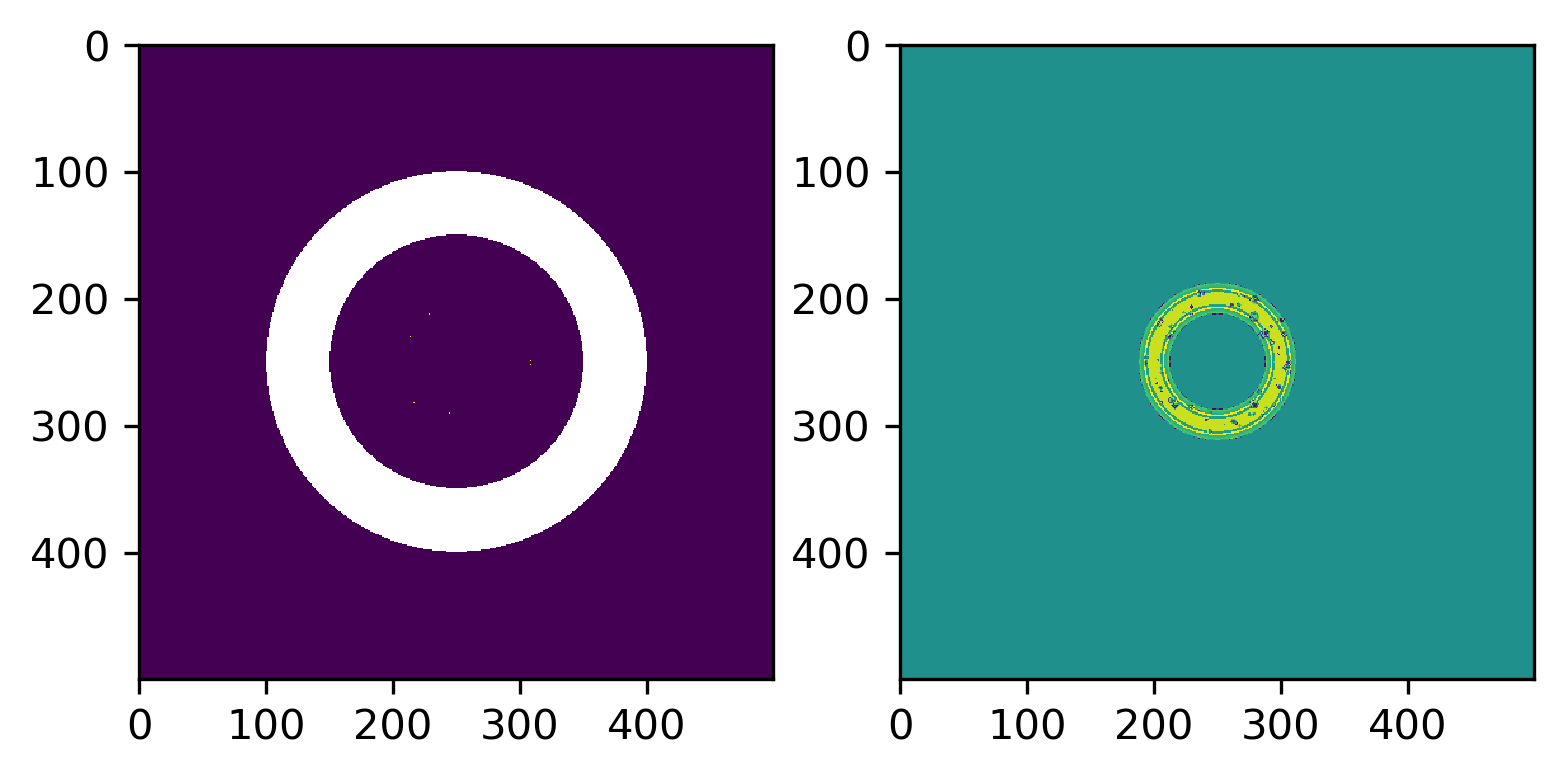

In [6]:
# np.exp(-wavevector*np.sum(rotation_Rz(magnitude,angle),axis=0))*np.exp(-1j*wavevector*np.sum(rotation_Rz(phase,angle),axis=0))
test = np.exp(-wavevector*np.sum(magnitude,axis=0))*np.exp(-1j*wavevector*np.sum(phase,axis=0))
absol = -np.log(np.abs(test))/wavevector
# absol = -np.abs(test)/wavevector
figure, ax = plt.subplots(1,2,dpi=300)
ax[0].imshow(absol)
ax[1].imshow(-np.angle(test)/wavevector)

## Rotate and get projections 

In [7]:
if 0:
    angles = np.linspace(0,180,2*N)
else:
    angles = np.array([0])

get_projection_partial = partial(get_projection,magnitude=magnitude,phase=phase,wavevector=wavevector)

if 1:
    sinogram = np.zeros((angles.shape[0],phantom.shape[1],phantom.shape[2]),dtype=complex)
    processes = min(os.cpu_count(),32)
    print(f'Using {processes} parallel processes')
    with ProcessPoolExecutor(max_workers=processes) as executor:
        results = list(tqdm(executor.map(get_projection_partial,angles),total=len(angles)))
        for counter, result in enumerate(results):
            if counter % 100 == 0: print('Populating results matrix...',counter)
            sinogram[counter,:,:] = result
    np.save(os.path.join(path,'complex_sinogram.npy'),sinogram)
else:
    sinogram = np.load(os.path.join(path,'complex_sinogram.npy'))

Using 32 parallel processes


100%|██████████| 1/1 [00:45<00:00, 45.47s/it]


Populating results matrix... 0


## Probe and Diffraction Patterns

(800, 800)
Probe shape (400, 400)


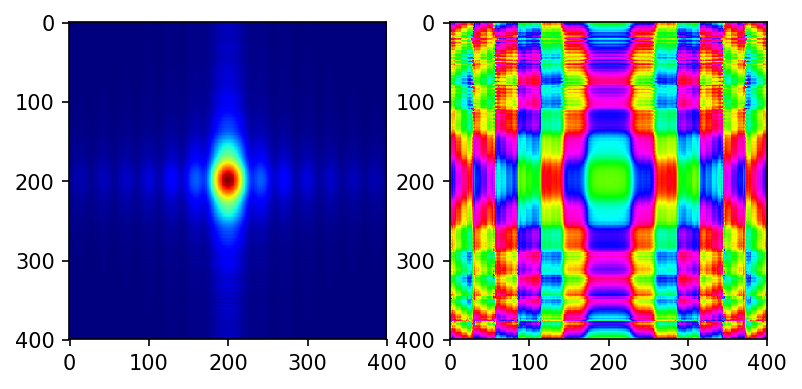

Creating dataset 0/1
Reading probe positions (probe_positions)...
Done


In [8]:
if 1: # Realistic Probe """
    probe = np.load(os.path.join(path,'model','probe_at_focus_1.25156micros_pixel.npy'))
    print(probe.shape)
    half=200
    probe = probe[probe.shape[0]//2-half:probe.shape[0]//2+half,probe.shape[1]//2-half:probe.shape[1]//2+half]
    
else: #Round probe """
    probe = np.ones((100,100))
    xprobe = np.linspace(0,probe.shape[0]-1,probe.shape[0])
    xprobe -= probe.shape[0]//2
    Y,X = np.meshgrid(xprobe,xprobe)
    probe = np.where(X**2+Y**2<=45**2,1,0)
print("Probe shape", probe.shape)

figure, ax = plt.subplots(1,2,dpi=150)
ax[0].imshow(np.abs(probe),cmap='jet')
ax[1].imshow(np.angle(probe),cmap='hsv')
plt.show()

obj_pxl   = get_object_pixel(probe.shape[0],probe_pxl,wavelength,distance)
real_space_shape = (int(phantom.shape[0]+probe.shape[0]//2),int(phantom.shape[1]+probe.shape[1]//2))
save_hdf_masks(path,probe.shape)

""" Loop through all frames"""
for i in range(sinogram.shape[0]):
    if i%10==0: print(f"Creating dataset {i}/{sinogram.shape[0]}")
    filename = str(i).zfill(4)+f"_complex_phantom"
    difpads = get_difpads2(sinogram[0],probe,obj_pxl,wavelength,distance,filename,path)
    
    """ Save to hdf file """
    create_hdf_file(difpads,path,filename)

    difpads = np.squeeze(difpads)
    np.save(os.path.join("/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/proc/recons/complex_phantom",f'{filename}_001.hdf5.npy'),difpads)
    np.save(os.path.join("/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/data/ptycho3d/complex_phantom/",f'{filename}_001.hdf5.npy'),difpads)
print("Done")